In [1]:

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [3]:
#CHANGE HERE TO PATH WHERE NPZ FILE FOR POST DISASTER IS

# LOADING TENSORS
#to recover images and mask arrays:
loaded_arrays_post = np.load('/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/data/npz files/tensors_pre_guatemala_volcano.npz')




In [4]:
# getting images and masks from post tensors

images_post = loaded_arrays_post['images']
masks_post = loaded_arrays_post['masks']
id_post = loaded_arrays_post['id'] # file names for each image-mask pair


In [ ]:
# getting images and masks from post tensors

images_post = loaded_arrays_post['images']
masks_post = loaded_arrays_post['masks']
id_post = loaded_arrays_post['id'] # file names for each image-mask pair


In [5]:
X = images_post
y = masks_post

print(len(X), len(y)) 
print (X[0].shape)
print (y[0].shape)
print(id_post.shape)

12 12
(1024, 1024, 3)
(1024, 1024, 1)
(12,)


In [6]:
# SPLITTING
train_X, val_X,train_y, val_y= train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )

In [7]:

# develop tf Dataset objects
#train_X = tf.data.Dataset.from_tensor_slices(train_X)
#val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_dataset = tf.data.Dataset.from_tensor_slices((train_X,train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_X,val_y))

#train_y = tf.data.Dataset.from_tensor_slices(train_y)
#val_y = tf.data.Dataset.from_tensor_slices(val_y)
#print(len(train_X) ,len(val_X),len(train_y),len(val_y))
# verify the shapes and data types
train_dataset.element_spec, val_dataset.element_spec
print(len(train_dataset))
print(len(val_dataset))


9
3


In [8]:
def map_fn(image, mask):
    # Assign names to the elements in the dataset
    return {"image": image, "segmentation_mask": mask}

named_dataset_train = train_dataset.map(map_fn)
named_dataset_val = val_dataset.map(map_fn)



In [9]:
# here we could try with nearest instead bilinear
# to solve the problem of getting pixels with categories
# that do not exist after resizing
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    #input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}    

In [10]:
auto = tf.data.AUTOTUNE
batch_size = 4

train = (
    named_dataset_train
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
val = (
    named_dataset_val
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

In [11]:
import matplotlib.pyplot as plt

def convert_mask_to_3_channels(mask_1_channel):
    """convert 1 channel mask (numpy array) in 3 channel mask, preserving labels 
    defined in "category_colors" dictionary
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    # Assuming mask_1_channels has shape (height, width, 1)
    height, width, _ = mask_1_channel.shape

    # Create an empty array with shape (height, width, 1) for the single-channel mask
    deep_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Define the colors representing each category (RGB values)
    category_colors = {
        0:(0, 0, 0),        # Class 0 - Black (no building) or un-classified
        1:(255, 255, 255),  # Class 1 - White (no-damage)
        2:(255,255,0),     # Class 2 - Yellow (minor damage)
        3:(255,165,0),     # Class 3 - Orange (major damage)
        4:(255, 0, 0),     # Class 4 - Red (destroyed)
    }
    # Loop through each pixel and assign the corresponding category to the single-channel mask
    for y in range(height):
        for x in range(width):
            pixel_color = mask_1_channel[y, x, 0]
            category = category_colors.get(pixel_color, (-1,-1,-1))  # -1 for unknown category
            deep_mask[y, x] = category

    return deep_mask

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    # Create the folder if it doesn't exist
    plt.show()


In [12]:

# def calculate_iou(y_true, y_pred):
#     intersection = np.logical_and(y_true, y_pred)
#     union = np.logical_or(y_true, y_pred)
#     iou = np.sum(intersection) / np.sum(union)
#     return iou

# def calculate_dice_coefficient(y_true, y_pred):
#     intersection = np.logical_and(y_true, y_pred)
#     dice_coefficient = 2.0 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
#     return dice_coefficient

# def calculate_pixel_accuracy(y_true, y_pred):
#     pixel_accuracy = np.mean(y_true == y_pred)
#     return pixel_accuracy




In [13]:
def create_mask_single(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=0)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask

In [14]:
# Load the saved model from the "saved_model" directory
# takes about 2min
from transformers import TFSegformerForSemanticSegmentation

loaded_model =  TFSegformerForSemanticSegmentation.from_pretrained("segmentation_model_test1_last_subset_no_augm", local_files_only=True)
#

# # Use the loaded model to make predictions on new data
predictions = loaded_model.predict(val)  # Replace 'inputs' with your new data

# # 'predictions' will contain the logits or probabilities, depending on the model's configuration

# # If you need the predicted masks, you can use the 'create_mask' function you defined earlier
# predicted_masks = create_mask(predictions.logits)


2023-08-07 21:04:00.928734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b7533f90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-07 21:04:00.928773: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-07 21:04:00.943755: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at segmentation_model_test1_last_subset_no_augm.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


1/1 [==============================] - 4s 4s/step


In [15]:
from sklearn.metrics import f1_score

def count_pixel_categories(flat_array):
    categories_per_pixel = {}
    for cat in flat_array:
        if cat in categories_per_pixel:
            categories_per_pixel[cat] += 1
        else:
            categories_per_pixel[cat] = 1
    return categories_per_pixel


def calc_f1_score_per_class(dataset=None):
    f1_per_class = {}
    n_total = 0
    if dataset:
        for sample in dataset:
            
            print("entering in loop for sample")
            #print(n_total)
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)

            #print(images.shape,masks.shape)
            pred_masks = loaded_model.predict(images).logits
            #print(pred_masks.shape)
            #print(final_pred_masks.shape)
            for i in range(0,len(images)):
                image = images[i,:,:,:]
                mask= masks[i,:,:]
                pred_mask = pred_masks[i,:,:,:]
                #print(image.shape,mask.shape,pred_mask.shape)
                final_pred_mask = create_mask_single(pred_mask)
                #print(final_pred_mask.shape)
                final_pred_mask=tf.image.resize(final_pred_mask, (512, 512), method="nearest")
                #print(mask.shape,final_pred_mask.shape)
                
                #pred_mask = loaded_model.predict(image).logits

                real = np.array(mask).astype(int).flatten()  # Flatten the real mask
                predicted = np.array(final_pred_mask).astype(int).flatten()  # Flatten the predicted mask
                # printing info f1 per category
                print("real classes: ",np.unique(real))
                print("predicted classes: ",np.unique(predicted))
                print("categories per pixel real image: ",count_pixel_categories(real))
                
                # Calculate the F1 score per class
                unique_labels = np.unique(np.concatenate((real, predicted)))
                print("label","f1")
                for label in unique_labels:
                    f1 = f1_score(real == label, predicted == label)
                    

                    print(label,f1)
                    f1_per_class[label] = f1_per_class.get(label, 0) + f1
                # to plot
                image = tf.transpose(image, (1, 2, 0))

                mask_deep=convert_mask_to_3_channels(np.array(mask))

                pred_mask_create_3ch = convert_mask_to_3_channels(np.array(final_pred_mask))
                
                display([image, mask_deep, pred_mask_create_3ch])

                n_total += 1

    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(loaded_model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )

    # Calculate the average F1 score per class
    for label, f1_total in f1_per_class.items():
        f1_per_class[label] = f1_total / n_total

    return f1_per_class

1
entering in loop for sample
1/1 [==============================] - 3s 3s/step
real classes:  [0 1]
predicted classes:  [0 1]
categories per pixel real image:  {0: 259527, 1: 2617}
label f1
0 0.9962918037135788
1 0.5282465150403521


/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/ipykernel_42308/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


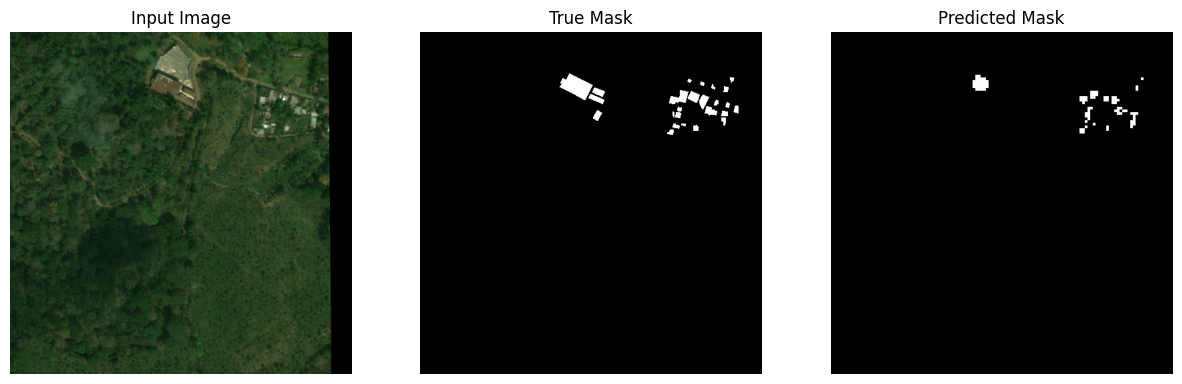

real classes:  [0 1]
predicted classes:  [0 1]
categories per pixel real image:  {0: 243255, 1: 18889}
label f1
0 0.9848135485409875
1 0.7795175373686547


/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/ipykernel_42308/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


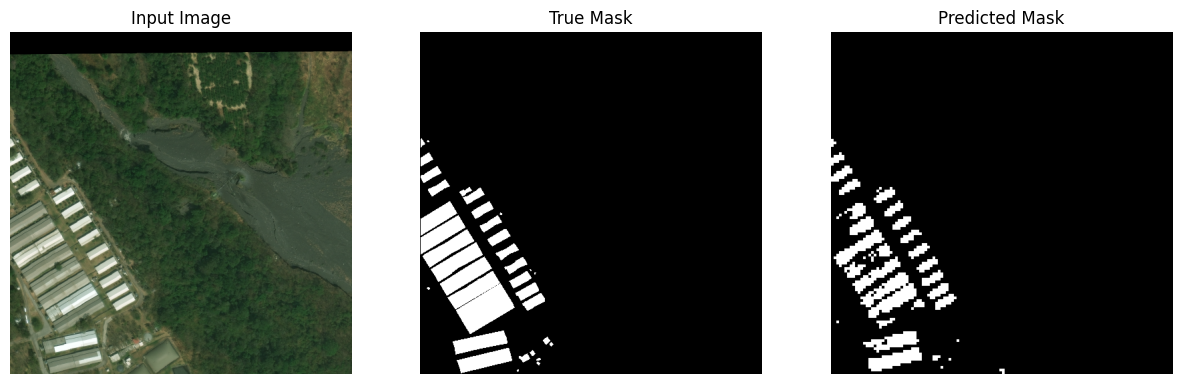

real classes:  [0 1]
predicted classes:  [0 1]
categories per pixel real image:  {0: 253676, 1: 8468}
label f1
0 0.9859125365355217
1 0.63139896373057


/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/ipykernel_42308/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


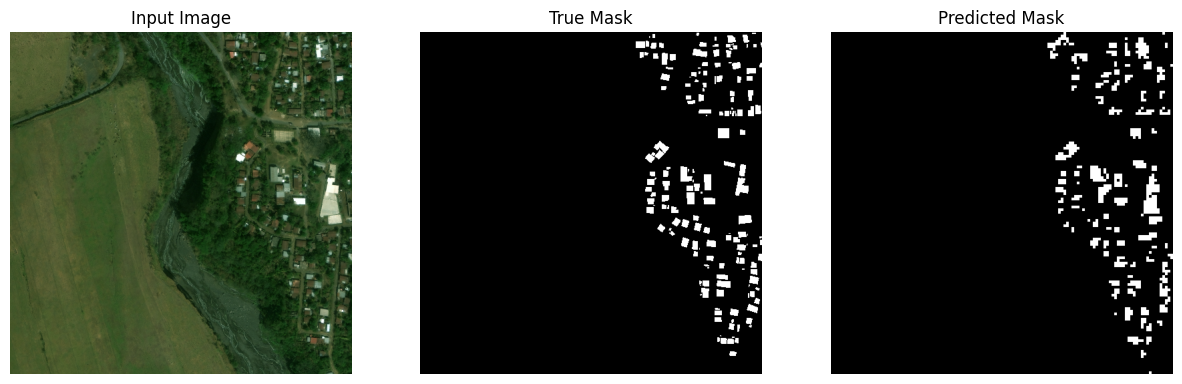

{0: 0.9890059629300293, 1: 0.6463876720465257}

In [16]:
print(len(val))
calc_f1_score_per_class(val)